In [5]:
import msprime
import tskit
import itertools
import random
import math
import numpy as np
from IPython.display import display, SVG

In [32]:
def truncate_ts_samples(ts, average_span, random_seed, min_span=5):
    """
    Create a tree sequence that has sample nodes which have been truncated
    so that they span only a small region of the genome. The length of the
    truncated spans is given by a poisson distribution whose mean is average_span
    but which cannot go below a fixed min_span, or above the sequence_length

    Samples are truncated by removing the edges that connect them to the rest
    of the tree.
    """
    def keep_with_offset(keep, data, offset):
       """Copied from keep_intervals"""
       # We need the astype here for 32 bit machines
       lens = np.diff(offset).astype(np.int32)
       return (data[np.repeat(keep, lens)],
               np.concatenate([
                   np.array([0], dtype=offset.dtype),
                   np.cumsum(lens[keep], dtype=offset.dtype)]))
    np.random.seed(random_seed)
    # Make a list of (left,right) tuples giving the new limits of each sample
    # Keyed by sample ID.
    to_slice = {}
    # for simplicity, we pick lengths from a poisson distribution of av 300 bp
    for sample_id, span in zip(
            ts.samples(), np.random.poisson(average_span, ts.num_samples)):
        span = max(span, min_span)
        span = min(span, ts.sequence_length)
        start = np.random.uniform(0, ts.sequence_length-span)
        to_slice[sample_id] = (start, start+span)

    tables = ts.dump_tables()
    tables.edges.clear()
    for e in ts.tables.edges:
        if e.child not in to_slice:
            left, right = e.left, e.right
        else:
            if e.right <= to_slice[e.child][0] or e.left >= to_slice[e.child][1]:
                continue  # this edge is outside the focal region
            else:
                left = max(e.left, to_slice[e.child][0])
                right = min(e.right, to_slice[e.child][1])
        tables.edges.add_row(left, right, e.parent, e.child)
    # Remove mutations above isolated nodes
    mutations = tables.mutations
    keep_mutations = np.ones((mutations.num_rows,), dtype = bool)
    positions = tables.sites.position[:]
    for i, m in enumerate(mutations):
        if m.node in to_slice:
            if to_slice[m.node][0] <= positions[m.site] < to_slice[m.node][1]:
                keep_mutations[i] = False
    new_ds, new_ds_offset = keep_with_offset(
        keep_mutations, mutations.derived_state, mutations.derived_state_offset)
    new_md, new_md_offset = keep_with_offset(
        keep_mutations, mutations.metadata, mutations.metadata_offset)
    mutations_map = np.append(np.cumsum(keep_mutations) - 1, [-1])
    mutations_map = mutations_map.astype(mutations.parent.dtype)
    # parent -1 always maps to parent -1
    tables.mutations.set_columns(
        site=mutations.site[keep_mutations],
        node=mutations.node[keep_mutations],
        derived_state=new_ds,
        derived_state_offset=new_ds_offset,
        parent=mutations_map[mutations.parent[keep_mutations]],
        metadata=new_md,
        metadata_offset=new_md_offset)
    return tables.tree_sequence()

ts = msprime.simulate(10, Ne=1e2, length=400, recombination_rate=1e-4, mutation_rate=2e-4, random_seed=1)
truncated_ts = truncate_ts_samples(ts, average_span=200, random_seed=123)

In [33]:
print(truncated_ts.genotype_matrix())
for h in truncated_ts.haplotypes():
    print(h)

[[-1 -1 -1 -1 -1 -1 -1 -1  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1  0 -1 -1  0 -1]
 [-1 -1 -1 -1 -1  0 -1 -1  0 -1]
 [-1 -1 -1  0 -1  1  1 -1  1 -1]
 [-1 -1 -1  0  0  0  0 -1  0  0]
 [-1 -1 -1  0  0  0  0 -1  0  0]
 [-1 -1 -1  0  0  0  0 -1  0  0]
 [-1 -1 -1  0  0  1  1 -1  1  1]
 [ 1  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  1  1  0  1  1]
 [ 0  0  1  0  0  1  1  0  1  1]
 [ 1  1  0  1  1  0  0  1  0  0]
 [ 0  0  1  0  0  1  1  0  1  1]
 [ 0  0  1  0  0  1  1  0  1  1]
 [ 0  0  0  0  0  1  1  0  1  1]
 [ 1  1  0  1  1  0  0  1  0  0]
 [ 0  0  1  0  0  1  1  0  1  1]
 [ 1  1  0  1  1  0  0  1  0  0]
 [ 1  1  0  1  1  0  0  1  0  0]
 [ 1  1  0  1  1  0  0  1  0  0]
 [ 0  0  0  0  0  1  1  0  1  1]
 [ 0  0  0  0  0  1  1  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1  0  0 -1  0]
 [ 0  0  0 -1  0 -1 -1  0 -1  0]
 [ 1  1  0

In [24]:
# Construct a tree sequence with integerized breakpoints
length = 50
recomb_map = msprime.RecombinationMap.uniform_map(length, rate=0.05, num_loci=length)
ts = msprime.simulate(8, mutation_rate=0.1, recombination_map=recomb_map, random_seed=1)

sentinel_allele = b"\0"
states = np.array(['a','t','g','c'], dtype='|S1')

tables = ts.dump_tables()
tables.sites.clear()
tables.mutations.clear()
for integer_pos, sites_at_pos in itertools.groupby(ts.sites(), lambda x: math.floor(x.position)):
  ancestral_state = random.choice(states)
  site_id = tables.sites.add_row(integer_pos, ancestral_state)
  # Order mutations by time
  mutations = []
  for site in sites_at_pos:
    mutations.extend(site.mutations)
  mutations.sort(key = lambda x: ts.node(x.node).time, reverse=True)
  for m in mutations:
    # Assign mutations with null parents & derived_states (will be filled in later)
    tables.mutations.add_row(site_id, m.node, derived_state=sentinel_allele, parent=tskit.NULL)

# Assign parents
tables.compute_mutation_parents()

# Assign derived states (use an array of chars)
ancestral_states = tables.sites.ancestral_state.view(dtype='|S1')
mutation_derived_state = np.full(tables.mutations.num_rows, sentinel_allele, dtype='|S1')
for i, m in enumerate(tables.mutations):
    if m.parent == tskit.NULL:
        prev_state = ancestral_states[m.site]
    else:
        prev_state = mutation_derived_state[m.parent]
    # Pick a new state that is different from the old one
    new_state = random.choice([s for s in states if s != prev_state])
    mutation_derived_state[i] = new_state

tables.mutations.derived_state = mutation_derived_state.view(tables.mutations.derived_state.dtype)

finite_sites_ts = tables.tree_sequence()

# Try printing them out
for h in finite_sites_ts.haplotypes():
  print(h)

gacgctcgggggcgacgtggaattat
gcccctgggcgtgggagtggacttat
tcccgctagtgttgacgactaattat
ggagatcgtcgttgacgacttgcgaa
ggagatcgtcgttgacgacttgcgaa
gacgctcggcggggacgtggaattat
tcccgctggtgttgacgacttgcgta
gacgctcggcggggacgtggaattat


In [25]:
truncated_ts = truncate_ts_samples(finite_sites_ts, average_span=20, random_seed=123)

In [26]:
sts = truncated_ts.simplify(keep_unary=True)

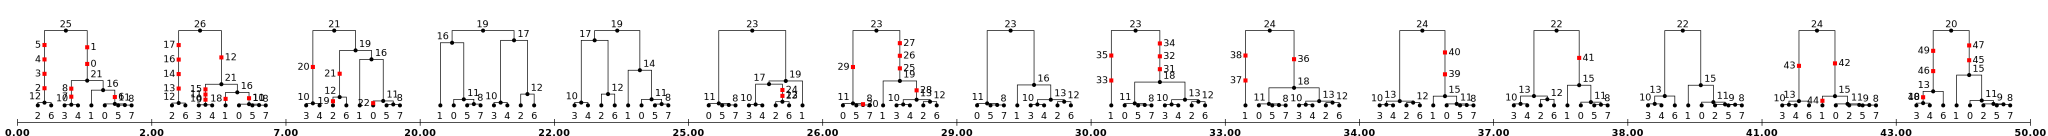

In [27]:
display(SVG(finite_sites_ts.draw_svg()))

In [28]:
def check_parents(ts):
    for m in ts.tables.mutations:
        if m.parent == tskit.NULL:
            old_state = "R"
        else:
            old_state = ts.mutation(m.parent).derived_state
        if old_state == m.derived_state:
            print(old_state, m.derived_state)
        
check_parents(truncated_ts)

In [29]:
for h in truncated_ts.haplotypes():
    print(h)

--------gcggcgacgtgg------
---------cgtggatat--------
---------tgttgacgact------
-----------ttgacgacttgc---
----------gttgacgactt-----
---------cggggacgtgg------
----------gttgacgactt-----
-------ggcg---------------


In [30]:
t = truncated_ts.dump_tables()
print(truncated_ts.samples())
print(truncated_ts.site(truncated_ts.num_sites-1))
t.mutations.add_row(node = 0, site = t.sites.num_rows-1, derived_state="g")
truncated_ts2 = t.tree_sequence()

[0 1 2 3 4 5 6 7]
{'id': 25, 'position': 48.0, 'ancestral_state': 't', 'mutations': [{'id': 44, 'site': 25, 'node': 13, 'derived_state': 'a', 'parent': -1, 'metadata': b''}], 'metadata': b''}


In [31]:
print(truncated_ts.genotype_matrix().T)
for v in truncated_ts.variants():
    print(v)

[[-1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  3  0  0  1  1  1  1  1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  1  2  0  0  0  0  1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  0  1  0  0  0  1  1  0  0  0 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  0  0  0  1  1  0  0  0  0  1  0 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0  0  0  1  1  0  0  0  0 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  2  0  0  1  1  1  1  1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0  0  0  1  1  0  0  0  0 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]]
{'site': {'id': 0, 'position': 0.0, 'ancestral_state': 'g', 'mutations': [{'id': 0, 'site': 0, 'node': 21, 'derived_state': 't', 'parent': -1, 'metadata': b''}, {'id': 1, 'site': 0, 'node': 21, 'derived_state': 'g', 'parent': 0, 'metadata': b''}, {'id': 2, 'site': 0, 'node': 12, 'derived_state': 'c', 'parent': -1, 'metadata': b''}, {

In [2]:
import msprime

ts = msprime.simulate(4, random_seed=1)
tables = ts.dump_tables()
tables.sites.add_row(ancestral_state = "a", position = 0.2)
tables.mutations.add_row(derived_state = "b", site = 0, node = 4)
tables.mutations.add_row(derived_state = "a", site = 0, node = 0)

print(tables.tree_sequence().genotype_matrix())

tables.edges.clear()
for e in ts.edges():
    tables.edges.add_row(left=0.5 if e.child==0 else e.left, right=e.right, parent=e.parent, child=e.child)

print(tables.tree_sequence().draw_text())
print(tables.tree_sequence().genotype_matrix())



[[0 1 0 0]]
2.70┊     6    ┊   6     ┊  
    ┊    ┏┻━┓  ┊ ┏━┻━┓   ┊  
1.98┊    ┃  5  ┊ ┃   5   ┊  
    ┊    ┃ ┏┻┓ ┊ ┃ ┏━┻┓  ┊  
0.18┊    ┃ ┃ 4 ┊ ┃ ┃  4  ┊  
    ┊    ┃ ┃ ┃ ┊ ┃ ┃ ┏┻┓ ┊  
0.00┊ 0  2 3 1 ┊ 2 3 1 0 ┊  
  0.00       0.50      1.00 



LibraryError: Inconsistent mutations: state already equal to derived state